NFL PLAYING SURFACE ANALYTICS - COMPREHENSIVE EDA
Loading data...
PlayList shape: (267005, 15)
InjuryRecord shape: (104, 9)
Loading PlayerTrackData...
PlayerTrackData shape: (25010207, 20)
Correction factor: 5.784

Generating comprehensive EDA visualization...

Comprehensive EDA figure saved to: nfl_surface_eda_comprehensive.png

EDA generation complete!


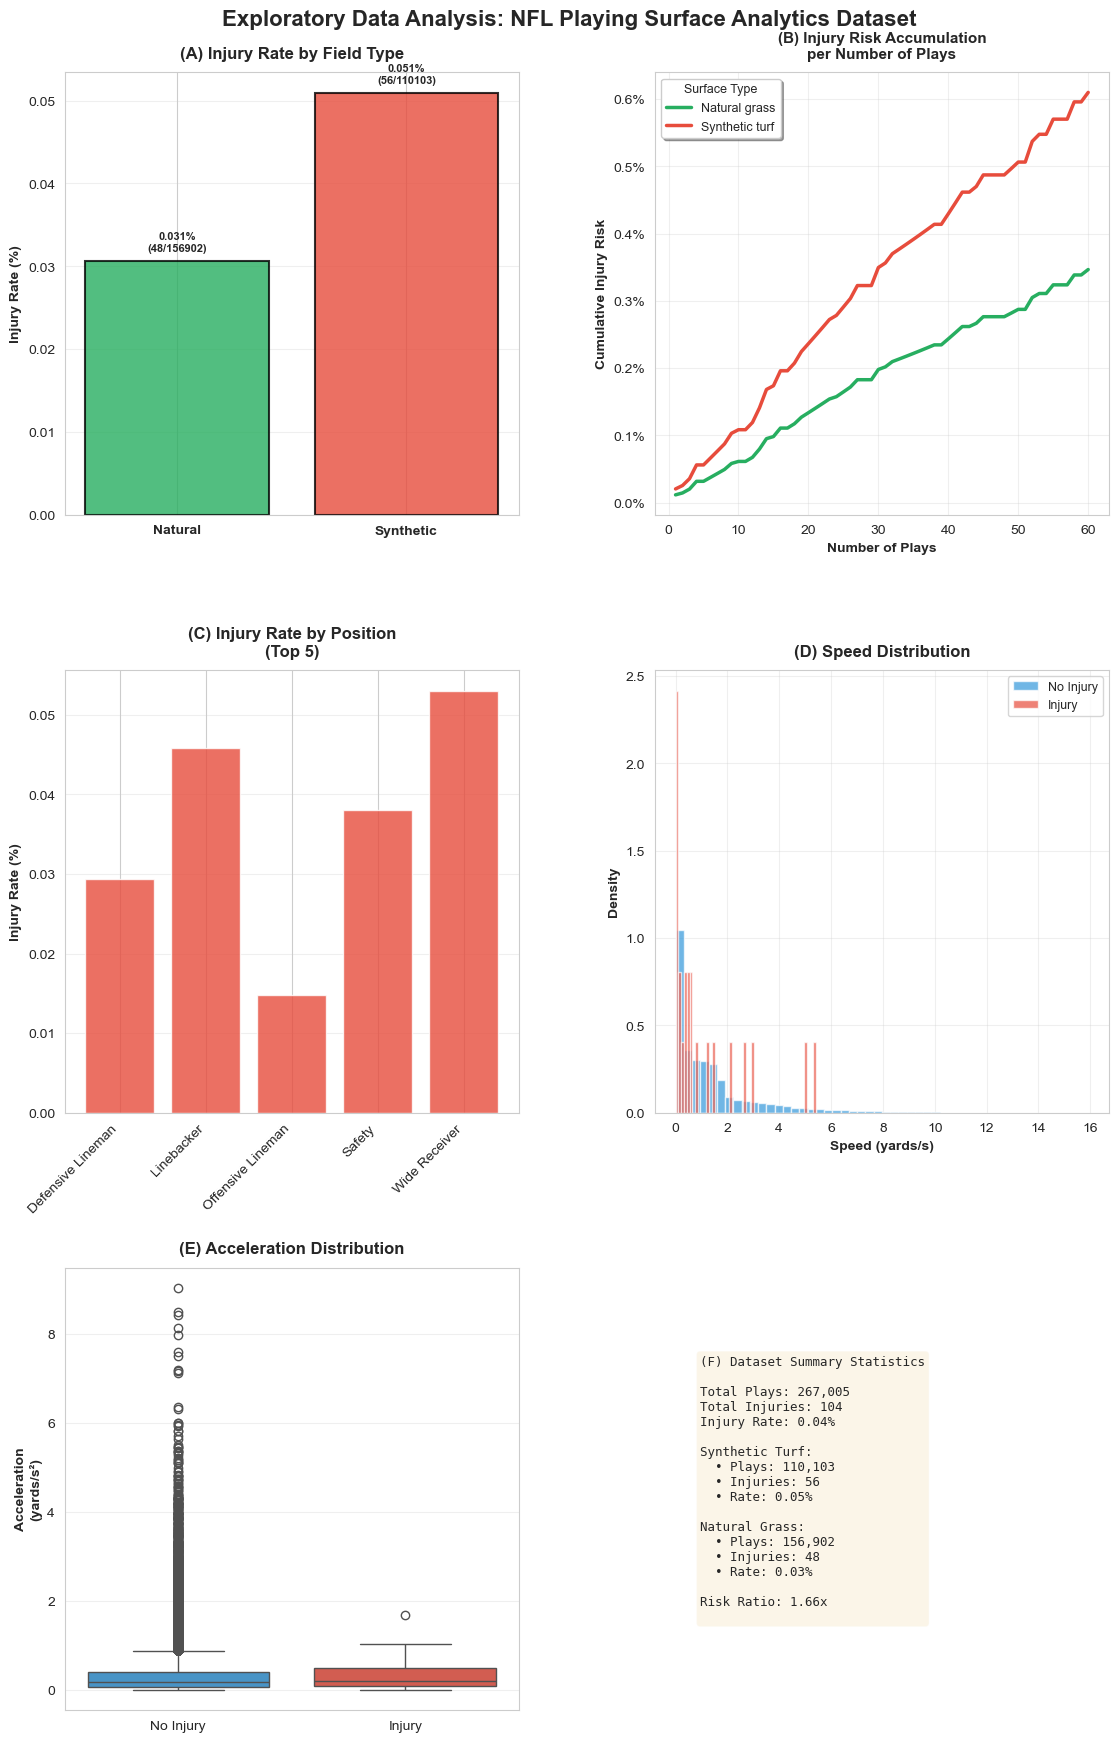

In [1]:
"""
NFL Playing Surface Analytics - Comprehensive EDA Visualization

This script creates a comprehensive 6-panel exploratory data analysis figure
in a 3x2 layout, focusing on playing surface analytics.
"""

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
import warnings
warnings.filterwarnings("ignore")

# Import from data_loader
from data_loader import load_and_preprocess_data, csq_test


def create_comprehensive_eda(PlayList, InjuryRecord, PlayerTrackData, corr_term,
                              output_file='nfl_surface_eda_comprehensive.png'):
    """
    Create a comprehensive EDA figure with 6 panels in 3x2 layout.

    Parameters:
    -----------
    PlayList : pd.DataFrame
        Play-level data
    InjuryRecord : pd.DataFrame
        Injury records
    PlayerTrackData : pd.DataFrame
        Player tracking data
    corr_term : float
        Bias correction term
    output_file : str
        Output filename for the figure
    """

    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['font.size'] = 10

    # Create figure with 3x2 grid (6 plots total, tall and skinny)
    fig = plt.figure(figsize=(12, 18))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.30, top=0.95, bottom=0.04, left=0.08, right=0.95)

    # Main title with more space from the top
    fig.suptitle('Exploratory Data Analysis: NFL Playing Surface Analytics Dataset',
                 fontsize=16, fontweight='bold', y=0.985)

    # Color scheme
    color_no_injury = '#3498db'  # Blue
    color_injury = '#e74c3c'      # Red
    color_synthetic = '#e74c3c'   # Red
    color_natural = '#27ae60'     # Green

    # ========================================================================
    # (A) Injury Rate by Field Type - Bar chart showing percentages
    # ========================================================================
    ax_a = fig.add_subplot(gs[0, 0])

    # Calculate injury rates by field type
    field_stats = PlayList.groupby('FieldType')['DM_M1'].agg(['sum', 'count'])
    field_stats['rate'] = (field_stats['sum'] / field_stats['count'] * 100)

    bars = ax_a.bar(range(len(field_stats)), field_stats['rate'].values,
                    color=[color_natural, color_synthetic], alpha=0.8, edgecolor='black', linewidth=1.5)

    ax_a.set_xticks(range(len(field_stats)))
    ax_a.set_xticklabels(field_stats.index, fontweight='bold')
    ax_a.set_ylabel('Injury Rate (%)', fontweight='bold')
    ax_a.set_title('(A) Injury Rate by Field Type', fontweight='bold', pad=10)
    ax_a.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, (idx, row) in enumerate(field_stats.iterrows()):
        ax_a.text(i, row['rate'] + 0.001, f'{row["rate"]:.3f}%\n({int(row["sum"])}/{int(row["count"])})',
                 ha='center', va='bottom', fontsize=8, fontweight='bold')

    # ========================================================================
    # (B) Injury Risk Over Time (Plays) - Line plot with risk accumulation
    # ========================================================================
    ax_b = fig.add_subplot(gs[0, 1])

    # Cox Proportional Hazards model for plays
    target = 'DM_M1'
    df = PlayList[PlayList[target] >= PlayList.groupby('PlayerKey')[target].cumsum()]
    df = df.groupby(['GameID']).last().reset_index()[['PlayerKey', 'PlayKey', 'PlayerGamePlay', target, 'FieldType']]
    df['FieldSynthetic'] = (df['FieldType'] == "Synthetic").astype(int)

    cph = CoxPHFitter()
    cph.fit(df[['FieldSynthetic', 'PlayerGamePlay', target]], duration_col='PlayerGamePlay', event_col=target)

    play_preds = (1 - cph.predict_survival_function(pd.DataFrame({"PlayerGamePlay":[0,0], "FieldSynthetic":[0,1]}))[:60]) / corr_term
    play_preds.columns = ['Natural grass', 'Synthetic turf']

    # Prepare data for seaborn
    play_data = play_preds.reset_index()
    play_data.columns = ['Plays', 'Natural grass', 'Synthetic turf']
    play_data_melted = play_data.melt(id_vars='Plays', var_name='Surface Type', value_name='Injury Risk')

    sns.lineplot(data=play_data_melted, x='Plays', y='Injury Risk', hue='Surface Type',
                 palette={'Synthetic turf': color_synthetic, 'Natural grass': color_natural},
                 linewidth=2.5, ax=ax_b)

    ax_b.set_title('(B) Injury Risk Accumulation\nper Number of Plays',
                   fontsize=11, fontweight='bold', pad=10)
    ax_b.set_xlabel('Number of Plays', fontsize=10, fontweight='bold')
    ax_b.set_ylabel('Cumulative Injury Risk', fontsize=10, fontweight='bold')
    ax_b.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    ax_b.legend(title='Surface Type', fontsize=9, title_fontsize=9, frameon=True, shadow=True)
    ax_b.grid(True, alpha=0.3)

    # ========================================================================
    # (C) Injury Rate by Position - Bar chart (was E)
    # ========================================================================
    ax_c = fig.add_subplot(gs[1, 0])

    # Get top 10 positions by frequency
    top_positions = PlayList['RosterPosition'].value_counts().head(10)

    # Calculate injury rate by top positions
    injury_by_pos = PlayList[PlayList['RosterPosition'].isin(top_positions.index[:5])].groupby('RosterPosition')['DM_M1'].agg(['sum', 'count'])
    injury_by_pos['rate'] = injury_by_pos['sum'] / injury_by_pos['count'] * 100

    ax_c.bar(range(len(injury_by_pos)), injury_by_pos['rate'].values, color=color_injury, alpha=0.8)
    ax_c.set_xticks(range(len(injury_by_pos)))
    ax_c.set_xticklabels(injury_by_pos.index, rotation=45, ha='right')
    ax_c.set_ylabel('Injury Rate (%)', fontweight='bold')
    ax_c.set_title('(C) Injury Rate by Position\n(Top 5)', fontweight='bold', pad=10)
    ax_c.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # (D) Speed Distribution - Histogram with overlays (was F)
    # ========================================================================
    ax_d = fig.add_subplot(gs[1, 1])

    # Sample PlayerTrackData for performance
    sample_size = min(100000, len(PlayerTrackData))
    ptd_sample = PlayerTrackData.sample(n=sample_size, random_state=42)

    # Filter out extreme values
    speed_data = ptd_sample[ptd_sample['s'].between(0, 20)]

    ax_d.hist(speed_data[speed_data['DM_M1'] == 0]['s'], bins=50, alpha=0.7,
              color=color_no_injury, label='No Injury', density=True)
    ax_d.hist(speed_data[speed_data['DM_M1'] == 1]['s'], bins=50, alpha=0.7,
              color=color_injury, label='Injury', density=True)

    ax_d.set_xlabel('Speed (yards/s)', fontweight='bold')
    ax_d.set_ylabel('Density', fontweight='bold')
    ax_d.set_title('(D) Speed Distribution', fontweight='bold', pad=10)
    ax_d.legend(fontsize=9)
    ax_d.grid(True, alpha=0.3)

    # ========================================================================
    # (E) Acceleration Distribution - Box plot (was G)
    # ========================================================================
    ax_e = fig.add_subplot(gs[2, 0])

    # Filter acceleration data
    accel_data = ptd_sample[ptd_sample['a'].between(0, 10)][['a', 'DM_M1']].copy()
    accel_data['Injury Status'] = accel_data['DM_M1'].map({0: 'No Injury', 1: 'Injury'})

    sns.boxplot(x='Injury Status', y='a', data=accel_data,
                palette={'No Injury': color_no_injury, 'Injury': color_injury},
                ax=ax_e)

    ax_e.set_xlabel('', fontweight='bold')
    ax_e.set_ylabel('Acceleration\n(yards/s²)', fontweight='bold')
    ax_e.set_title('(E) Acceleration Distribution', fontweight='bold', pad=10)
    ax_e.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # (F) Field Type Summary Statistics - Text box (was H)
    # ========================================================================
    ax_f = fig.add_subplot(gs[2, 1])
    ax_f.axis('off')

    # Calculate statistics
    total_plays = len(PlayList)
    total_injuries = PlayList['DM_M1'].sum()
    synthetic_plays = (PlayList['FieldType'] == 'Synthetic').sum()
    natural_plays = (PlayList['FieldType'] == 'Natural').sum()
    synthetic_injuries = PlayList[PlayList['FieldType'] == 'Synthetic']['DM_M1'].sum()
    natural_injuries = PlayList[PlayList['FieldType'] == 'Natural']['DM_M1'].sum()

    stats_text = f"""(F) Dataset Summary Statistics

Total Plays: {total_plays:,}
Total Injuries: {int(total_injuries)}
Injury Rate: {total_injuries/total_plays*100:.2f}%

Synthetic Turf:
  • Plays: {synthetic_plays:,}
  • Injuries: {int(synthetic_injuries)}
  • Rate: {synthetic_injuries/synthetic_plays*100:.2f}%

Natural Grass:
  • Plays: {natural_plays:,}
  • Injuries: {int(natural_injuries)}
  • Rate: {natural_injuries/natural_plays*100:.2f}%

Risk Ratio: {(synthetic_injuries/synthetic_plays)/(natural_injuries/natural_plays):.2f}x
"""

    ax_f.text(0.1, 0.5, stats_text, fontsize=9, verticalalignment='center',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
              family='monospace')

    # Save figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\nComprehensive EDA figure saved to: {output_file}")

    return fig


def main():
    """Main function to run the comprehensive EDA."""

    print("="*70)
    print("NFL PLAYING SURFACE ANALYTICS - COMPREHENSIVE EDA")
    print("="*70)

    # Load data
    InjuryRecord, PlayList, PlayerTrackData, corr_term = load_and_preprocess_data()

    # Create comprehensive EDA figure
    print("\nGenerating comprehensive EDA visualization...")
    fig = create_comprehensive_eda(PlayList, InjuryRecord, PlayerTrackData, corr_term)

    print("\nEDA generation complete!")
    print("="*70)


if __name__ == "__main__":
    main()
